In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import regularizers, layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, StandardScaler

from tensorflow.keras.models import Model

from time import time

In [2]:
data = pd.read_csv('./dataset/creditCardActivity/creditcard.csv', engine='pyarrow')
raw_data = data.values
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Separate normal transactions from fraudulent transactions
normal_data = data[data['Class'] == 0]
normal_data_sample = normal_data.sample(4000)
fraud_data = data[data['Class'] == 1]

# reduced_set = pd.concat([normal_data_sample, fraud_data]).reset_index(drop=True)
reduced_set = pd.concat([normal_data_sample, fraud_data.sample(frac=1)]).reset_index(drop=True)

# Splitting the dataset into X and y features
y_reduced = reduced_set['Class']
X_reduced = reduced_set.drop('Class', axis=1)
X_reduced = X_reduced.drop('Time', axis=1)

# X.to_json('test_data.json', orient='records')

y = data['Class']
X = data.drop('Class', axis=1)
X = X.drop('Time', axis=1)

test_normal = normal_data.drop('Class', axis=1)
test_fraud = fraud_data.drop('Class', axis=1)
test_normal = test_normal.drop('Time', axis=1)
test_fraud = test_fraud.drop('Time', axis=1)

print(f"Reduced dataset shape : {reduced_set.shape}")
print(f"Shape of Features : {X.shape} and Target: {y.shape}")

Reduced dataset shape : (4492, 31)
Shape of Features : (284807, 29) and Target: (284807,)


In [9]:
# Visualise the data
def dimensionality_plot(X, y):
    sns.set(style='whitegrid', palette='muted')
    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate=200)
    # Fitting the data
    X_trans = tsne.fit_transform(X)

    plt.figure(figsize=(12, 8))

    plt.scatter(X_trans[np.where(y == 0), 0], X_trans[np.where(y == 0), 1], marker='o', color='blue', linewidth=1, alpha=0.8, label='Normal')
    plt.scatter(X_trans[np.where(y == 1), 0], X_trans[np.where(y == 1), 1], marker='o', color='orange', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best')

    plt.show()

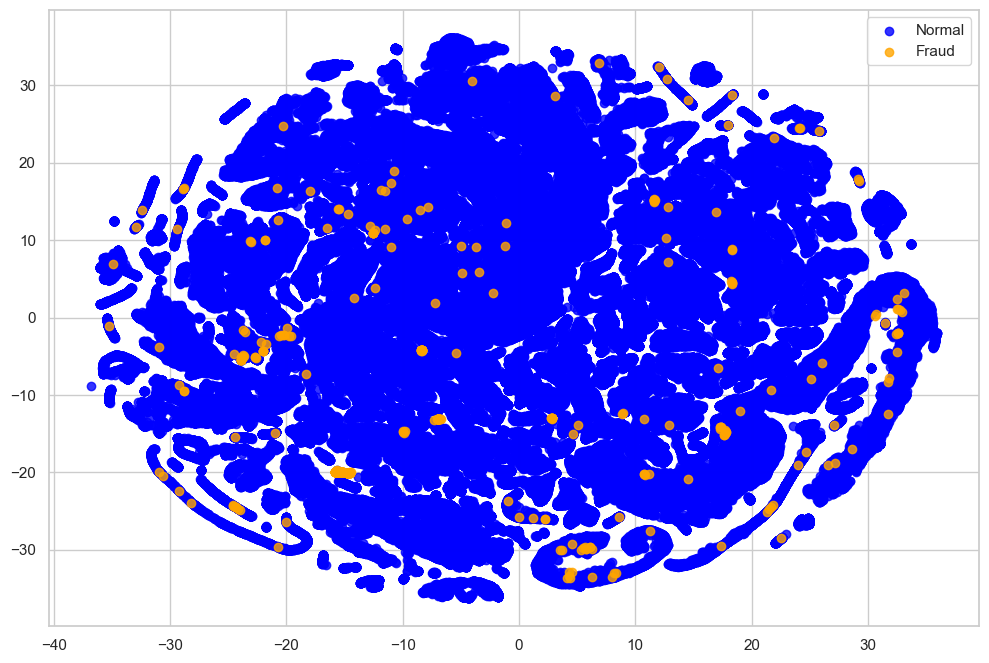

In [54]:
dimensionality_plot(X, y)

In [6]:
print(f"Shape of the input data : {X.shape[1]}")

Shape of the input data : 29


In [7]:
# Convert relative 'Time' to hour of day
# data['Time'] = data['Time'].apply(lambda t: (t / 3600) % 24)

# Scale Time and Amount
# data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
# data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# Better accuracy
data = data.drop(['Time'], axis=1)

train_x, test_x = train_test_split(data, test_size=0.2, random_state=736)
train_x = train_x[train_x['Class'] == 0]    # train only on normal transactions data
train_x = train_x.drop(['Class'], axis=1)   # drop the class column

test_x_normal = test_x[test_x['Class'] == 0].sample(5000)
test_x_normal = test_x_normal.drop(['Class'], axis=1).values
test_x_fraud = test_x[test_x['Class'] == 1]
test_x_fraud = test_x_fraud.drop(['Class'], axis=1).values

test_normal_sample = normal_data_sample.drop(['Class'], axis=1)
test_fraud_sample = fraud_data.drop(['Class'], axis=1)
# test_normal_sample = normal_data_sample.drop(['Time'], axis=1)
# test_fraud_sample = fraud_data.drop(['Time'], axis=1)

test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

test = test_x.sample(1)

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [12]:
hyperparams = {
    "epochs": 150,
    "batch_size": 32,
    "threshold": 0.75
}

In [ ]:
# Build the model :)
class deprecated_FraudDetector(Model):

    def __init__(self):
        super(deprecated_FraudDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(18, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(10, activation='relu'),
            layers.Dense(6, activation='tanh', activity_regularizer=regularizers.l1(1e-7))])

        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(18, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(30, activation='relu')]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# Build the model :)
class FraudDetector(Model):

    def __init__(self):
        super(FraudDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(29, activation='relu', input_shape=(29, )),
            layers.Dense(14, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(7, activation='tanh', activity_regularizer=regularizers.l1(1e-7))]
        )

        self.decoder = tf.keras.Sequential([
            layers.Dense(14, activation='tanh', activity_regularizer=regularizers.l1(1e-7)),
            layers.Dense(29, activation='relu')]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

    def decode(self, encoded_x):
        return self.decoder(encoded_x)

In [ ]:
# Build the model :)
class deprecated_SimpleDetector(Model):

    def __init__(self):
        super(deprecated_SimpleDetector, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(30, activation='relu', input_shape=(30, )),
            layers.Dense(14, activation='relu'),
            layers.Dense(7, activation='relu')]
        )

        self.decoder = tf.keras.Sequential([
            layers.Dense(14, activation='relu'),
            layers.Dense(30, activation='relu')]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
autoencoder = FraudDetector()

# Compule the model
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mse')

# Train the model
history = autoencoder.fit(x=train_x, y=train_x, batch_size=hyperparams['batch_size'], epochs=hyperparams['epochs'], shuffle=True, validation_data=(test_x, test_x))

Epoch 1/150


2023-05-27 11:55:41.773719: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-27 11:55:42.079594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7108/7108 [==============================] - ETA: 0s - loss: 2197.7036 - accuracy: 0.8605

2023-05-27 11:56:27.803844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7108/7108 [==============================] - 52s 7ms/step - loss: 2197.7036 - accuracy: 0.8605 - val_loss: 2029.9727 - val_accuracy: 0.8668
Epoch 2/150
7108/7108 [==============================] - 51s 7ms/step - loss: 1900.4969 - accuracy: 0.8663 - val_loss: 1788.4967 - val_accuracy: 0.8682
Epoch 3/150
7108/7108 [==============================] - 52s 7ms/step - loss: 1703.8138 - accuracy: 0.8682 - val_loss: 1616.9645 - val_accuracy: 0.8705
Epoch 4/150
7108/7108 [==============================] - 52s 7ms/step - loss: 1557.6892 - accuracy: 0.8707 - val_loss: 1483.4159 - val_accuracy: 0.8483
Epoch 5/150
7108/7108 [==============================] - 52s 7ms/step - loss: 1441.0825 - accuracy: 0.8725 - val_loss: 1375.3243 - val_accuracy: 0.8727
Epoch 6/150
7108/7108 [==============================] - 52s 7ms/step - loss: 1347.1909 - accuracy: 0.8731 - val_loss: 1287.7931 - val_accuracy: 0.8791
Epoch 7/150
7108/7108 [==============================] - 52s 7ms/step - loss: 1268.8242 - accuracy: 

In [ ]:
autoencoder.info

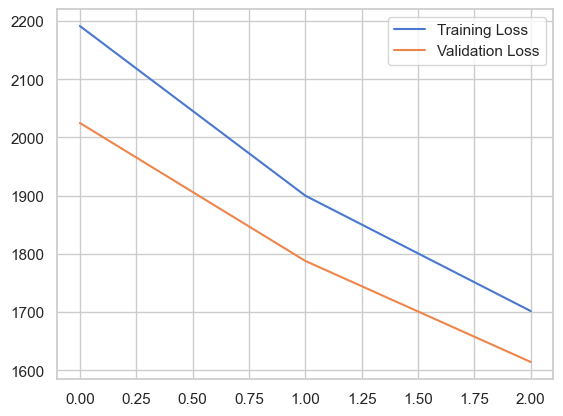

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [56]:
# normal_points = autoencoder.predict(test_normal_sample)
# fraud_points = autoencoder.predict(test_fraud_sample)

# normal_points = autoencoder.predict(test_x_normal)
# fraud_points = autoencoder.predict(test_x_fraud)

normal_points = autoencoder.predict(test_normal)
fraud_points = autoencoder.predict(test_fraud)

encoded_X = np.append(normal_points, fraud_points, axis=0)
y_normal = np.zeros(normal_points.shape[0])
y_fraud = np.ones(fraud_points.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis=0)

16/16 [==============================] - 0s 2ms/step


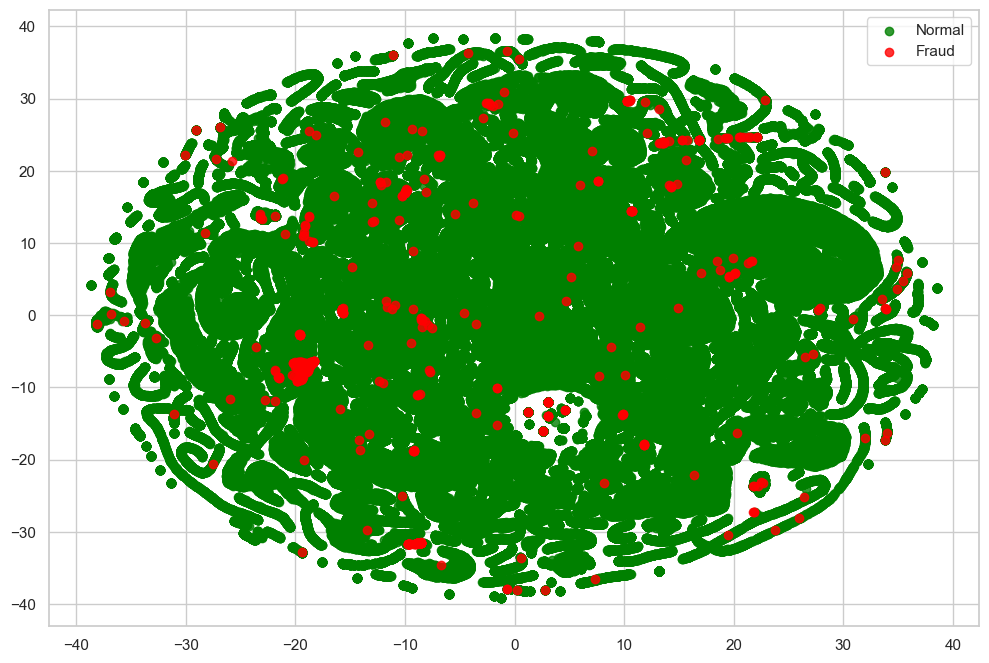

In [57]:
dimensionality_plot(encoded_X, encoded_y)

In [ ]:
normal_points = autoencoder.predict(test_normal_sample)
fraud_points = autoencoder.predict(test_fraud_sample)

mse = np.mean(np.square(test_fraud_sample - fraud_points), axis=1)
mse

In [ ]:
predictions = autoencoder.predict(test)
mse = np.mean(np.power(test_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test_y})
error_df.describe()
test

In [ ]:
# Reconstruction error without fraud
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [ ]:
# Reconstruction error with fraud
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
# Prediction analysis

error_threshold = 2.9

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', color="r" if name == 1 else "g", ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(error_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="b", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [ ]:
# confusion matrix

y_pred = [1 if e > error_threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [58]:
ts = int(time())
filepath = f'../models/fraud_detector/{ts}'
autoencoder.save(filepath=filepath, save_format='tf')

INFO:tensorflow:Assets written to: ../models/fraud_detector/1685177095/assets
